In [ ]:
from torch import nn
import torch as t
from tqdm import tqdm

## data

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

In [ ]:
batch_size = 32
epochs=2
latent_dim_size = 10
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.2),
                             ])

mnist_train = MNIST(root="mnist", download=True, transform=transform, train=True)
mnist_eval = MNIST(root="mnist", download=True, transform=transform, train=False)
trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
evalloader = DataLoader(mnist_eval, batch_size=batch_size, shuffle=False)


## train loop

In [ ]:
def train(autoencoder: nn.Module, trainloader: DataLoader, optimizer):
    criterion = nn.MSELoss()
    autoencoder.train()
    pbar = tqdm(enumerate(trainloader), total=trainloader.__len__())
    for epoch in range(epochs):
        for i, (images, labels) in pbar:
            type(images)
            optimizer.zero_grad()
            decompressed_images = autoencoder(images)
            loss = criterion(decompressed_images, images)
            loss.backward()
            optimizer.step()
            if i%10== 0:
                pbar.set_postfix(loss = loss.detach())


## eval

In [ ]:
def eval(autoencoder: nn.Module, evalloader: DataLoader):
    autoencoder.eval()
    criterion = nn.MSELoss()
    pbar = tqdm(enumerate(evalloader), total=len(evalloader))
    saved_loss = []
    for i, (images, labels) in pbar:
        decompressed_images = autoencoder(images)
        loss = criterion(decompressed_images, images)
        saved_loss.append(loss.detach().mean())
        if i%10== 0:
            pbar.set_postfix(loss = loss.detach())
    
    print("loss", t.mean(t.tensor(saved_loss)))

## show result

In [ ]:
from matplotlib import pyplot as plt
import einops
def show(autoencoder:nn.Module, evalloader: DataLoader):
    autoencoder.eval()
    generator = enumerate(evalloader)
    _, (images,labels) = next(generator)
    reconstructed = autoencoder(images).detach()
    reconstructed = einops.rearrange(reconstructed, "b c h w -> h (b c w)")
    images = einops.rearrange(images, "b c h w -> h (b c w)")
    plt.imshow(t.cat((reconstructed,images)))
    plt.show()

## Linear Autoencoder

Use an encoder with just two fully connected linear layers, with one activation function in the middle. Your first linear layer should have out_features=100, and you should try a small number for your second linear layer (e.g. between 2 and 10). Your decoder architecture should mirror your encoder, just like how the generator and discriminator mirrored each other in the GAN you created yesterday.

In [ ]:
from einops.layers.torch import Rearrange

class Autoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, *args):
        super().__init__()
        self.image_size = 28
        self.encoder = nn.Sequential(Rearrange("b c h w -> b (c h w)"),
                                nn.Linear(in_features=self.image_size**2, out_features=100),
                                nn.ReLU(),
                                nn.Linear(in_features=100, out_features=latent_dim_size))
        self.decoder = nn.Sequential(nn.Linear(in_features=latent_dim_size, out_features=100),
                                    nn.ReLU(),
                                    nn.Linear(in_features=100, out_features=self.image_size**2),
                                    Rearrange("b (c h w) -> b c h w", h=self.image_size, w=self.image_size))

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

autoencoder = Autoencoder()

optimizer = t.optim.Adam(autoencoder.parameters())

In [ ]:
train(autoencoder=autoencoder, trainloader=trainloader, optimizer=optimizer)
eval(autoencoder=autoencoder, evalloader=evalloader)
show(autoencoder=autoencoder,evalloader=evalloader)

## Convolutional autoencoder

#### Encoder

Your encoder should consist of two convolutional layers, a flatten, then two linear layers. After each convolution or linear layer (except for the last one) you should have an activation function. The convolutions should have kernel size 4, stride 2, padding 0 (recall from yesterday that this exactly halves the width and height). The number of output channels can be 16 and 32 respectively.

After the convolutional layers, you flatten then apply linear layers. Your flattened size will be 32 \times 7 \times 732×7×7. Your first linear layer should have out_features=128; the second is up to you (again we recommend playing around with values between 2 and 10).

#### Decoder
Again, your decoder should be a mirror image of your encoder. Reverse the order of all the layers, and replace the convolutions with transposed convolutions. Your transposed convolutions should have kernel size 4, stride 2, and padding 1 (this results in a doubling of the height and width of the image, so you can use the same shapes for the linear layers as for the encoder, but in reverse).

In [ ]:
from einops.layers.torch import Rearrange

class ConvolutionalAutoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, *args, **kwargs):
        super().__init__()
        self.image_size = 28
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.channels=32
        features_after_convolutions = int((self.image_size/4)**2*self.channels)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride,padding=self.padding),
                                    nn.GELU(),
                                    nn.Conv2d(in_channels=self.channels,out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride,padding=self.padding),
                                    nn.GELU(),
                                    Rearrange("b c h w -> b (c h w)"),
                                    nn.Linear(in_features=features_after_convolutions, out_features=100),
                                    nn.GELU(),
                                    nn.Linear(in_features=100, out_features=10))
        self.decoder = nn.Sequential(nn.Linear(in_features=10, out_features=100),
                                    nn.GELU(),
                                    nn.Linear(in_features=100, out_features=features_after_convolutions),
                                    nn.GELU(),
                                    Rearrange("b (c h w) -> b c h w", c=self.channels, h=int(7), w=int(7)),
                                    nn.ConvTranspose2d(in_channels=self.channels, out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
                                    nn.GELU(),
                                    nn.ConvTranspose2d(in_channels=self.channels, out_channels=1,kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),)
                                    

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

autoencoder = ConvolutionalAutoencoder()

optimizer = t.optim.Adam(autoencoder.parameters())

In [ ]:
train(autoencoder=autoencoder, trainloader=trainloader, optimizer=optimizer)
eval(autoencoder=autoencoder, evalloader=evalloader)
show(autoencoder=autoencoder,evalloader=evalloader)

## explore latent space

In [ ]:
from einops import rearrange
device="cpu"
model=autoencoder
import numpy as np
import plotly.express as px

# Choose number of interpolation points
n_points = 11

# Constructing latent dim data by making two of the dimensions vary independently between 0 and 1
latent_dim_data = t.zeros((n_points, n_points, latent_dim_size), device=device)
x = t.linspace(-1, 1, n_points)
latent_dim_data[:, :, 0] = x.unsqueeze(0)
latent_dim_data[:, :, 1] = x.unsqueeze(1)
# Rearranging so we have a single batch dimension
latent_dim_data = rearrange(latent_dim_data, "b1 b2 latent_dim -> (b1 b2) latent_dim")

# Getting model output, and normalising & truncating it in the range [0, 1]
output = model.decoder(latent_dim_data).detach().cpu().numpy()
output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
output_single_image = rearrange(output_truncated, "(b1 b2) 1 height width -> (b1 height) (b2 width)", b1=n_points)

# Plotting results
fig = px.imshow(output_single_image, color_continuous_scale="greys_r")
fig.update_layout(
    title_text="Decoder output from varying first two latent space dims", title_x=0.5,
    coloraxis_showscale=False, 
    xaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x]),
    yaxis=dict(tickmode="array", tickvals=list(range(14, 14+28*n_points, 28)), ticktext=[f"{i:.2f}" for i in x])
)
fig.show()

## Show embeddings of autoencoder

In [ ]:
from matplotlib import pyplot as plt
import einops

evalloader_bigbatch = DataLoader(mnist_eval, batch_size=1000, shuffle=False)
autoencoder.eval()
generator = enumerate(evalloader_bigbatch)
_, (images,labels) = next(generator)

embeddings = autoencoder.encoder(images).detach()

covariance_matrix = np.cov(embeddings.T)

values, vectors =  np.linalg.eig(covariance_matrix)

projected_embeddings = (embeddings @ vectors)[:,:2]

px.scatter(*projected_embeddings.T, color=labels)


# Variational Autoencoders

In [ ]:
from einops.layers.torch import Rearrange

class VariationalAutoencoder(nn.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(self, *args, **kwargs):
        super().__init__()
        self.image_size = 28
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.channels=32
        self.latent_dim = 10
        features_after_convolutions = int((self.image_size/4)**2*self.channels)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride,padding=self.padding),
                                    nn.GELU(),
                                    nn.Conv2d(in_channels=self.channels,out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride,padding=self.padding),
                                    nn.GELU(),
                                    Rearrange("b c h w -> b (c h w)"),
                                    nn.Linear(in_features=features_after_convolutions, out_features=100),
                                    nn.GELU(),
                                    nn.Linear(in_features=100, out_features=self.latent_dim*2), # 2 * latent dim for mean and variance of distributions
                                    Rearrange("b (l mv) -> b l mv", mv=2))
        self.decoder = nn.Sequential(nn.Linear(in_features=10, out_features=100),
                                    nn.GELU(),
                                    nn.Linear(in_features=100, out_features=features_after_convolutions),
                                    nn.GELU(),
                                    Rearrange("b (c h w) -> b c h w", c=self.channels, h=int(7), w=int(7)),
                                    nn.ConvTranspose2d(in_channels=self.channels, out_channels=self.channels,kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
                                    nn.GELU(),
                                    nn.ConvTranspose2d(in_channels=self.channels, out_channels=1,kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),)
                                    

    def forward(self, x: t.Tensor) -> t.Tensor:
        sample, log_variance, mean = self.sample_encoder(x=x)
        # input sample in the decoder
        reconstruction = self.decoder(sample)
        if self.training:
            return reconstruction, mean, log_variance # variance is the standard deviation in this case
        else:
            return reconstruction

    def sample_encoder(self, x:t.Tensor) -> t.Tensor:
        mean_and_variance = self.encoder(x)
        # isolate mean and variance
        mean, log_variance = mean_and_variance[..., 0], mean_and_variance[..., 1]
        # use exponential function to make sure variance is always positive
        variance = t.exp(log_variance)
        # sample fom the normal distributions
        sample = t.randn_like(mean)
        sample = sample*variance + mean
        return sample, log_variance, mean

autoencoder = VariationalAutoencoder()

optimizer = t.optim.Adam(autoencoder.parameters())

In [ ]:
def train_vae(autoencoder: nn.Module, trainloader: DataLoader, optimizer):
    criterion = nn.MSELoss()
    beta = 0.5
    autoencoder.train()
    pbar = tqdm(enumerate(trainloader), total=trainloader.__len__())
    for epoch in range(epochs):
        for i, (images, labels) in pbar:
            optimizer.zero_grad()
            decompressed_images, mean, log_variance = autoencoder(images)
            
            loss = criterion(decompressed_images, images) + t.mean(t.exp(log_variance * 2) + mean ** 2 - log_variance - 0.5)*beta
            loss.backward()
            optimizer.step()
            if i%10== 0:
                pbar.set_postfix(loss = loss.detach())

100%|██████████| 313/313 [00:04<00:00, 68.49it/s, loss=tensor(0.8309)]


loss tensor(0.7484)


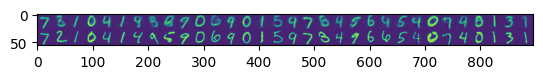

In [197]:
train_vae(autoencoder=autoencoder, trainloader=trainloader, optimizer=optimizer)
eval(autoencoder=autoencoder, evalloader=evalloader)
show(autoencoder=autoencoder,evalloader=evalloader)

In [ ]:
from matplotlib import pyplot as plt
import einops

evalloader_bigbatch = DataLoader(mnist_eval, batch_size=1000, shuffle=False)
autoencoder.eval()
generator = enumerate(evalloader_bigbatch)
_, (images,labels) = next(generator)

sample, _, _ = autoencoder.sample_encoder(images)

embeddings = sample.detach()

covariance_matrix = np.cov(embeddings.T)

values, vectors =  np.linalg.eig(covariance_matrix)

projected_embeddings = (embeddings @ vectors)[:,:2]

px.scatter(x=projected_embeddings[:,0], y=projected_embeddings[:,1], color=labels)


## showing the eigenvectors

In [195]:
decoded_eigenvectors = autoencoder.decoder(t.tensor(vectors, dtype=t.float32, requires_grad=False))
decoded_eigenvectors = rearrange(decoded_eigenvectors, "b c h w -> h (b c w)")
px.imshow(decoded_eigenvectors.detach().cpu().numpy())

### showing one hot vectors

In [196]:
one_hot = t.eye(autoencoder.latent_dim, dtype=t.float32)#*t.var(t.tensor(vectors))+t.mean(t.tensor(vectors))
decoded_one_hot = autoencoder.decoder(one_hot)
decoded_one_hot = rearrange(decoded_one_hot, "b c h w -> h (b c w)")
px.imshow(decoded_one_hot.detach().cpu().numpy())

### intermediate numbers

In [194]:
batch_size = 8
evalloader_bigbatch = DataLoader(mnist_eval, batch_size=batch_size, shuffle=False)
autoencoder.eval()
generator = enumerate(evalloader_bigbatch)
_, (images,labels) = next(generator)

fade_count = 8

linspace_up = t.linspace(0,1,fade_count)
linspace_down = t.linspace(1,0,fade_count)

sample, _, _ = autoencoder.sample_encoder(images)
sample = sample[...,None]
combined_vectors = t.repeat_interleave(sample[::2],fade_count,2)*linspace_down + t.repeat_interleave(sample[1::2],fade_count,2)*linspace_up
combined_vectors = rearrange(combined_vectors, "b l n -> (b n) l")
decoded_one_hot = autoencoder.decoder(combined_vectors)
decoded_one_hot = rearrange(decoded_one_hot, "(b n) c h w -> (b h) (n c w)", n=fade_count)
px.imshow(decoded_one_hot.detach().cpu().numpy(), title=f"labels = {rearrange(labels, '(l n) -> l n', l=batch_size//2)}")